In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 100 kB/s 


# Импорты

In [3]:
from google.colab import drive
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import re

import collections

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split


# инструменты для оценки точности модели 
from sklearn import metrics 
from sklearn.metrics import mean_absolute_percentage_error as mape


# модуль для работы с полиноминальными признаками
from sklearn.preprocessing import PolynomialFeatures


# Модули для визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# Модули для нахождения выбросов
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#
from IPython.display import display


# Модуль для вывода прогресса
from tqdm.notebook import tqdm

# Модули алгоритмов
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor  
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold


from sklearn.model_selection import GridSearchCV

# Настройки Pandas

In [4]:
# Настройки Pandas
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 20)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', 20)

# Функции для EDA

In [5]:
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

def get_quantile(df, column):
    #вычисляем межквартильный размах:
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = df[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = df[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr

    print('Верхняя граница выбросов:',
          l, 'Нижняя граница выбросов:', f)
    print()
    #считаем количество выбросов
    print('Количество выбросов:', column, ':',
         df[df[column]<(perc25-1.5*iqr)][column].count() +
          df[df[column]>(perc75+1.5*iqr)][column].count())
    
def get_filling_mean(df, column):
    
    #вычисляем межквартильный размах:
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = df[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = df[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr
    #всё что выпадает за границы выбросов, заменяем на среднее
    df[column] = df[column].apply(lambda m: df[column].mean() if m < f else m)
    df[column] = df[column].apply(lambda m: df[column].mean() if m > l else m)
    
def get_filling_lim(df, column):
    
    #вычисляем межквартильный размах:
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = df[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = df[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr
    #всё что выпадает за границы выбросов, заменяем на среднее
    df[column] = df[column].apply(lambda m: perc25 if m < f else m)
    df[column] = df[column].apply(lambda m: perc75 if m > l else m)


def get_filling_mean(df, column):
    
    #вычисляем межквартильный размах:
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = df[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = df[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr
    #всё что выпадает за границы выбросов, заменяем на среднее
    df[column] = df[column].apply(lambda m: df[column].mean() if m < f else m)
    df[column] = df[column].apply(lambda m: df[column].mean() if m > l else m)


# Функции

In [6]:
# Функции

# Функция для создания списка категорий
def quant_class(a):
    cnt = collections.Counter()
    for i in a:
        for j in i:
            j = str(j)
            cnt[j] += 1
    return cnt 

# Функция для создания DUMMY признаков из столбца 
def create_dummies(df, col, lst):
    for elem in lst:
        df[elem] = df[col].apply(lambda x: 1 if elem in x else 0)
    return df

# Функция для форматирования строк в списках столбца propertyType_1
def form_propertyType_1(x):
    a = []
    for i in x:
      if i[0] == ' ':
        i = i[1:]
      else: i = i
      a.append(i)
    return a

# Функция для форматирования строк в списках столбца propertyType_2
def form_propertyType_2(x):
    a = []
    for i in x:
      if i == 'co-op':
        i = 'coop'
      elif i == 'one story':
        i = '1 story'
      elif i == 'two story':
        i = '2 stories'
      elif i == '2 story':
        i = '2 stories'
      elif i == 'unknown':
        i = ' '
      elif i == '1 1':
        i = ' '
      elif i == 'townhome':
        i = 'townhouse'
      elif i == 'manufactured home':
        i = 'manufactured house'
      elif i == 'multi-family':
        i = 'multi family'
      elif i == ' ':
        i = ''
      a.append(i)
    return a


def form_fireplace_1(x):
    a = []
    for i in x:
      if i[0] == ' ':
        i = i[1:]
      else: i = i
      a.append(i)
    return a




def form_fireplace_2(x):
    a = []
    for i in x:
      if i == 'gas log':
        i = 'gas logs'
      elif i == 'gas fireplace':
        i = 'gas'
      elif i == 'one':
        i = '1'
      elif i == 'familyrm':
        i = 'family room'
      elif i == '# fireplaces - woodburning':
        i = '1, wood burning'
      elif i == '# fireplaces - gas':
        i = '1, gas'
      elif i == 'fireplaces':
        i = '1'
      elif i == '# fireplaces - woodstoves':
        i = 'woodstoves'
      elif i == 'gas fuel':
        i = 'gas'
      elif i == 'in great room':
        i = 'great room'
      elif i == 'familyrm':
        i = 'family room'
      elif i == 'in living room':
        i = 'living room'
      elif i == 'in den':
        i = 'den'
      elif i == '1 fireplace':
        i = '1'
      elif i == 'fireplace family rm':
        i = 'family room'
      elif i == 'woodburning stove':
        i = 'wood burning'
      elif i == 'log woodburning':
        i = 'wood burning'
      elif i == 'fireplace-gas':
        i = 'gas'
      elif i == 'gas fireplace':
        i = 'gas'
      elif i == 'log wood-burning':
        i = 'wood burning'
      elif i == 'fireplace-wood':
        i = 'wood burning'
      elif i == 'fire pit':
        i = 'firepit'
      elif i == 'fireplace living rm':
        i = 'living room'
      elif i == 'wood burning frplc':
        i = 'wood burning'
      elif i == 'fireplace - wood burning':
        i = 'wood burning'
      elif i == 'wood burning fp':
        i = 'wood burning'
      elif i == 'gas log starter':
        i = 'gas starter'
      elif i == 'no fireplace':
        i = '0'
      elif i == 'two':
        i = '2'
      elif i == '2 fireplaces':
        i = '2'
      elif i == 'fireplace':
        i = '1'
      elif i == 'three':
        i = '3'
      elif i == '2 fireplace':
        i = '2'
      elif i == 'in bedroom':
        i = 'bedroom'
      elif i == 'fireplace master bdr':
        i = 'bedroom'
      elif i == 'two way fireplace':
        i = 'two way'
      elif i == 'gas logs included':
        i = 'gas logs'
      elif i == 'living room fireplace':
        i = 'living room'
      elif i == 'single fireplace':
        i = '1'
      elif i == 'frplc-fam rm':
        i = 'family room'
      elif i == 'gr':
        i = 'great room'
      elif i == 'fireplace in family room':
        i = 'family room'
      elif i == 'gas burning fireplace':
        i = 'gas'
      elif i == 'fireplace - gas':
        i = 'gas'
      elif i == '3+ fireplace':
        i = '3'
      elif i == 'in rec room':
        i = 'rec room'
      elif i == 'gas burning':
        i = 'gas'
      elif i == 'freestnd fireplace':
        i = 'free standing'
      elif i == 'basement - finished':
        i = 'basement'
      elif i == 'family room fireplace':
        i = 'family room'
      elif i == 'wood burning fireplace':
        i = 'wood burning'
      elif i == 'gas log fireplace':
        i = 'gas logs'
      elif i == 'wood burning w':
        i = 'wood burning'
      elif i == 'great room fireplace':
        i = 'great room'
      elif i == 'location (living room)':
        i = 'living room'
      elif i == '3 fireplaces':
        i = '3'
      elif i == 'two sided':
        i = 'two way'
      elif i == 'fireplace-living rm':
        i = 'living room'
      elif i == 'fp in living room':
        i = 'living room'
      elif i == 'woodstove':
        i = 'wood stove'
      elif i == 'living':
        i = 'living room'
      elif i == 'free-standing':
        i = 'free standing'
      elif i == 'brick fireplace':
        i = 'brick'
      elif i == 'ceiling fan(s)':
        i = 'ceiling fan'
      elif i == 'walk-in closet(s)':
        i = 'walk-in closet'
      elif i == 'in kitchen':
        i = 'kitchen'
      elif i == 'basement fireplace':
        i = 'basement'
      elif i == '# fireplaces - freestanding':
        i = 'free standing'
      elif i == 'decorative fireplace':
        i = 'decorative'
      elif i == 'decorative only':
        i = 'decorative'
      elif i == 'fp in family room':
        i = 'family room'
      elif i == 'fireplace(s)':
        i = '1'
      elif i == '2+ fireplaces':
        i = '2'
      elif i == 'dining':
        i = 'dining room'
      elif i == 'multi-sided fireplace':
        i = 'two way'
      elif i == 'in family room':
        i = 'family room'
      elif i == '2 sided fire place':
        i = 'two way'
      elif i == 'in master bedroom':
        i = 'master bedroom'
      elif i == 'bedroom':
        i = 'master bedroom'
      elif i == 'master bedroom fireplace':
        i = 'master bedroom'
      elif i == 'fireplace-bedroom':
        i = 'master bedroom'
      elif i == 'master bedroom - sitting area':
        i = 'master bedroom'
      elif i == 'dining area':
        i = 'dining room'
      elif i == 'four or more':
        i = '4'
      elif i == 'wood stove insert':
        i = 'wood stove'
      elif i == 'fireplace- gas':
        i = 'gas'
      elif i == 'two-way':
        i = 'two way'
      elif i == 'wood-burning stove':
        i = 'wood stove'
      elif i == 'gas piped':
        i = 'gas'
      elif i == 'non wood burning': #?
        i = 'gas'
      elif i == 'wood fuel':
        i = 'wood stove'
      elif i == '# fireplaces - pellet':
        i = 'pellet'
      elif i == 'propane logs convey': #?
        i = 'gas'
      elif i == 'bed room fireplace':
        i = 'bed room'
      elif i == 'free standing wood stove': #?
        i = 'wood stove'
      elif i == 'masonry fireplace': 
        i = 'stone fireplace'
      elif i == 'masonry':
        i = 'stone fireplace'
      elif i == 'w':  #?
        i = 'wood stove'
      elif i == 'family':
        i = 'family room'
      elif i == 'recreation room fireplace':
        i = 'recreation room'
      elif i == 'rec room':
        i = 'recreation room'
      elif i == 'gas log(s)':
        i = 'gas logs'
      elif i == 'double sink': #?
        i = 'two way'
      elif i == 'in living area': 
        i = 'living room'
      elif i == 'fireplace in master bedroom':
        i = 'master bedroom'
      elif i == 'master':
        i = 'master bedroom'
      elif i == 'gas-burning':
        i = 'gas'
      elif i == '2 or more fireplaces':
        i = '2'
      elif i == 'gas starter fireplace':
        i = 'gas starter'
      elif i == 'master suite': 
        i = 'master bedroom'
      elif i == '2 sided fireplace': 
        i = 'two way'
      elif i == 'three or more':
        i = '3'
      elif i == 'electric logs':
        i = 'electric'
      elif i == 'electric fireplace':
        i = 'electric'
      elif i == 'fireplace - electric':
        i = 'electric'
      elif i == '4+ fireplaces':
        i = '4'
      elif i == 'formal dining room':
        i = 'dining room'
      elif i == 'double sink': 
        i = 'two way'
      elif i == 'multi sided': 
        i = 'two way'
      elif i == 'oven': #? 
        i = '1'
      elif i == 'attached fireplace doors':
        i = 'attached doors'
      elif i == 'balcony access':
        i = 'balcony'
      elif i == 'basement - partially finished':
        i = 'basement'
      elif i == 'bed room':
        i = 'bedroom'
      elif i == 'cable tv available': 
        i = 'cable tv'
      elif i == 'cathedral ceiling':  #?
        i = 'cathedral'
      elif i == 'ceiling fans':
        i = 'ceiling fan'
      elif i == 'central furnace': #?
        i = 'central air'
      elif i == 'central heat': #?
        i = 'central air'
      elif i == 'central vacuum': #? 
        i = 'central air'
      elif i == 'dining room combo':
        i = 'dining room'
      elif i == 'dining room fireplace':
        i = 'dining room'
      elif i == 'exterior fireplace':
        i = 'extras' #?
      elif i == 'fireplace- wood':
        i = 'wood burning'
      elif i == 'forced warm air': 
        i = 'forced air'
      elif i == 'fp in master br':  #?
        i = 'master bedroom'
      elif i == 'free standing frplc': #?
        i = 'free standing'
      elif i == 'freestanding': #? 
        i = 'free standing'
      elif i == 'gas starters':
        i = 'gas starter'
      elif i == 'gas ventless':
        i = 'gas unvented'
      elif i == 'heatilater':
        i = 'heatilator'
      elif i == 'heatilator type system':
        i = 'heatilator'
      elif i == 'heating system: yes(s)': 
        i = 'heatilator'
      elif i == 'in-law apt': 
        i = 'in-law quarters'
      elif i == 'in-law suite': 
        i = 'in-law quarters'
      elif i == 'insert unit':
        i = 'insert'
      elif i == 'kitchen - gas cooking':
        i = 'kitchen'
      elif i == 'kitchen fireplace':
        i = 'kitchen'
      elif i == 'marble fireplace':
        i = 'marble'
      elif i == 'master bedroom - dressing area': 
        i = 'master bedroom'
      elif i == 'natural gas': #?
        i = 'gas'
      elif i == 'non-functional fireplace': 
        i = 'non-functional'
      elif i == 'not applicable': 
        i = 'non-functional'
      elif i == 'other (see remarks)':
        i = 'other'
      elif i == 'other - see remarks':
        i = 'other'
      elif i == 'other-see remarks':
        i = 'other'
      elif i == 'outdoors':
        i = 'outdoor'
      elif i == 'outside':
        i = 'outdoor'
      elif i == 'pellet stove':
        i = 'pellet'
      elif i == 'pre-fab':
        i = 'prefabricated'
      elif i == 'prefab':
        i = 'prefabricated'
      elif i == 'presently inoperative':
        i = 'non-functional'
      elif i == 'propane': #?
        i = 'gas'
      elif i == 'propane stove': #?
        i = 'gas'
      elif i == 'rec room fireplace': 
        i = 'recreation room'
      elif i == 'see thru':   #?
        i = 'see through'
      elif i == 'separate dining':
        i = 'dining room'
      elif i == 'stone fireplace':
        i = 'stone'
      elif i == 'storage lockers':
        i = 'storage'
      elif i == 'vented gas fireplace':
        i = 'vented gas'
      elif i == 'walk-in closets':
        i = 'walk-in closet'
      elif i == 'wall mounted': #?
        i = 'wall furnace'
      elif i == 'window treatments': 
        i = 'window treatment'
      elif i == 'with gas logs': 
        i = 'gas logs'
      elif i == 'wood':
        i = 'wood burning'
      elif i == 'woodburning':
        i = 'wood burning'
      elif i == 'wood burning stove': 
        i = 'wood stove'
      elif i == 'woodstoves': 
        i = 'wood stove'
      elif i == 'in study': 
        i = 'study'

      a.append(i)
    return a


def form_homeFacts_re(x):
  x = re.sub(r': None,', ': "None",', x)
  x = re.sub(r'Attch"d', 'Attchd', x)
  x = re.sub(r'Req"d', 'Reqd', x)
  x = re.sub(r'Hennen"s', 'Hennens', x)
  x = re.sub(r'"closet"', 'closet', x)
  x = re.sub(r'Addtn"l', 'Addtnl', x)
  x = re.sub(r'Penske"s', 'Penskes', x)
  #x = x[20:-2]

  return x


# Загрузка датасета

In [7]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [8]:
!ls /content/gdrive/

MyDrive


In [9]:
!ls /content/gdrive/"My Drive"

'Colab Notebooks'   SWOT.gsheet		       'Новая таблица.gsheet'
 Colab_Notebooks    TEMNIAKOVA_08_2021.gsheet   Остальное
 datasets	    TEMNIAKOVA_08_2021.xls     'Таблицы DataScience'
 Diplom_project    'Книги по IT'


In [10]:
!cp /content/gdrive/'My Drive'/Diplom_project/data.csv .


In [11]:
!ls

data.csv  gdrive  sample_data


In [12]:
# Настройки Pandas
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [13]:
df = pd.read_csv('data.csv')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Target

In [ ]:
# Посмотрим если в Target есть пропуски
df['target'].isna().value_counts()

False    374704
True       2481
Name: target, dtype: int64

In [ ]:
# Удалим их
#df['target'].dropna(inplace = True)
df.dropna(subset = ['target'],inplace = True)

In [ ]:
# Ecть одно значение цены от и до суммы. обьявление аренды возьмем среднее етой цены.
df.target = df.target.apply(lambda x: '1326' if x == '$1,215 - $1,437/mo'  else x)

In [ ]:
# Убираем все знаки.
df.target = df.target.str.replace(r'\D+', '', regex=True)

In [ ]:
# Приведем все значения к float 
df.target = df.target.astype(float)

# Столбец 'status'

In [ ]:
df['status'] = df['status'].str.lower()

In [ ]:
# Создадим список из столбца status
status_list = df['status'].unique().tolist()

In [ ]:
# Функция для изменнения строк
def form_status(x):
  x = re.sub('foreclosure', 'for sale', x)
  x = re.sub('pending', 'for sale', x)
  x = re.sub('auction', 'for sale', x)
  x = re.sub('contract', 'for sale', x)
  x = re.sub('coming', 'for sale', x)
  x = re.sub('closed', 'for sale', x)
  x = re.sub('foreclosed', 'for sale', x)
  x = re.sub('price change', 'for sale', x)
  x = re.sub('back', 'for sale', x)
  x = re.sub('continue show', 'for sale', x)
  x = re.sub('listing', 'for sale', x)
  x = re.sub('accepting', 'for sale', x)
  x = re.sub('activated', 'for sale', x)
  x = re.sub('lease/purchase', 'for sale', x)
  x = re.sub('sold', 'active', x)
  x = re.sub('recently sold', 'active', x)
  x = re.sub('active - auction', 'for sale', x)


  return x

In [ ]:
# Заполним пропуски строками nan
df['status'].fillna('nan', inplace = True)
df.status = df.status.apply(form_status)

In [ ]:
# Выделим строки с ключевыми словами
nan = df.status.str.extract(r'(nan)')
active = df.status.str.extract('(active)')
for_sale = df.status.str.extract('(for sale)')
for_rent = df.status.str.extract('(for rent)')
new = df.status.str.extract('(new)')


In [ ]:
# Выделим соеденим результат в один столбец.
status = nan.where(active.isnull(), active)
status = status.where(for_sale.isnull(), for_sale)
status = status.where(for_rent.isnull(), for_rent)
status = status.where(new.isnull(), new)

In [ ]:
df.status = status

In [ ]:
df.status.value_counts()

for sale    220552
active      105750
nan          39504
new           6149
for rent       412
Name: status, dtype: int64

In [ ]:
len(df.status)

374704

In [ ]:
df.status.isna().value_counts()

False    372367
True       2337
Name: status, dtype: int64

In [ ]:
# Выделим строки с пропусками опять заполняем значением 'nan'
df['status'].fillna('nan', inplace = True)

In [ ]:
len(df.status)

374704

# Столбцы MlsId и mls-id

In [ ]:
# Столбцы MlsId и mls-id это айдишники обьявлений удаляем.
df.drop(['mls-id','MlsId'], axis = 1, inplace = True)

# Столбец 'private pool'

In [ ]:
# Посмотрим на признак 'private pool' 
print('Количество классов')
print(df['private pool'].value_counts())
print('Количество пропусков')
print(df['PrivatePool'].value_counts())

Количество классов
Yes    4151
Name: private pool, dtype: int64
Количество пропусков
yes    28687
Yes    11434
Name: PrivatePool, dtype: int64


In [ ]:
df['PrivatePool'] = pd.concat([df['private pool'].dropna(), df['PrivatePool'].dropna()]).reindex_like(df)

In [ ]:
df['PrivatePool'].value_counts()

yes    28687
Yes    15585
Name: PrivatePool, dtype: int64

In [ ]:
df['PrivatePool'] = df['PrivatePool'].str.lower()

In [ ]:
# Основная часть данных это пропуски зделаем из этого столбца бинарный признак
df['PrivatePool'] = df['PrivatePool'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
df['PrivatePool'].value_counts()

0    330432
1     44272
Name: PrivatePool, dtype: int64

In [ ]:
df.drop(['private pool'], inplace = True, axis = 1)

# Столбец 'propertyType' - dummy

### До dummy

In [ ]:
print(df['propertyType'].value_counts())

single-family home                                                                                                                   91376
Single Family                                                                                                                        61888
Single Family Home                                                                                                                   31725
condo                                                                                                                                25878
lot/land                                                                                                                             20532
Condo                                                                                                                                16494
townhouse                                                                                                                            11443
Land                       

In [ ]:
# Приведем все строки к нижнему регистру
df['propertyType'] = df['propertyType'].str.lower()

In [ ]:
# Большая часть данных это просто по разному расписаные несколько категорий
df['propertyType'] = df['propertyType'].apply(lambda x: 'single_family' if x == ('single-family home') or  (x == 'single family') or  (x == 'single family home') else x )
df['propertyType'] = df['propertyType'].apply(lambda x: 'condo' if x == 'Condo'  else x)
df['propertyType'] = df['propertyType'].apply(lambda x: 'land' if (x == 'Land') or (x == 'lot/land')  else x)
df['propertyType'] = df['propertyType'].apply(lambda x: 'multi-family' if x == 'multi-family home'  else x)
df['propertyType'] = df['propertyType'].apply(lambda x: '1 story' if x == 'one story'  else x)
df['propertyType'] = df['propertyType'].apply(lambda x: '2 stories' if (x == '2 story') or (x == 'two story')  else x)
df['propertyType'] = df['propertyType'].apply(lambda x: 'coop' if x == 'co-op'  else x)

In [ ]:
# Функция для изменения строк в столбце
def form_propertyType_s(x):
  x = str(x)
  x = re.sub('single', 'houses', x)
  x = re.sub('story', 'houses', x)
  x = re.sub('stories', 'houses', x)
  x = re.sub('bungalow', 'houses', x)
  x = re.sub('home', 'houses', x)
  x = re.sub('transitional', 'houses', x)
  x = re.sub('contemporary', 'houses', x)
  x = re.sub('stories', 'houses', x)
  x = re.sub('stories', 'houses', x)
  x = re.sub('residential','houses', x)
  x = re.sub('level','houses', x)
  x = re.sub('custom','houses',x)
  x = re.sub('cottage','houses',x)
  x = re.sub('house','houses',x)
  x = re.sub('detached','houses', x)
  x = re.sub('stor','houses', x)
  x = re.sub('attached','houses', x)
  x = re.sub('residential','houses', x)
  x = re.sub('coach','houses', x)

  x = re.sub('townhome', 'townhouse', x) 
  x = re.sub("plex", 'townhouse', x)

  x = re.sub('high rise', 'condo', x)
  x = re.sub('coop', 'condo', x)
  x = re.sub('coop', 'condo', x)
  x = re.sub('less than 4 floors','condo', x)
  x = re.sub('unit','condo',x)
  x = re.sub('co-op','condo', x)
  x = re.sub('rise','condo', x)
  x = re.sub('loft','condo', x)
  x = re.sub('penthouse', 'apartment', x)
  
  x = re.sub('lot', 'land', x)

  x = re.sub('multi', 'multi-family', x)
  x = re.sub('split','multi-family', x)

  x = re.sub('mediterranean','style house', x)
  x = re.sub('cape','style house', x)
  x = re.sub('modern','style house', x)
  x = re.sub('craftsman','style house',x)
  x = re.sub('victorian','style house', x)
  x = re.sub('spanish','style house',x)
  x = re.sub('miscellaneous','style house',x)
  x = re.sub('colonial','style house', x)
  x = re.sub('key west','style house',x)
  x = re.sub('santa barbara','style house', x)
  x = re.sub('straight','style house', x)
  x = re.sub('french','style house', x)
  x = re.sub('english','style house', x)
  x = re.sub('georgian','style house', x)
  x = re.sub('european','style house', x)
  x = re.sub('elevated','style house', x)
  x = re.sub('art','style house', x)
  x = re.sub('historical','style house',x)
  x = re.sub('frame','style house', x)
  x = re.sub('charleston','style house', x)
  x = re.sub('tudor','style house', x)
  x = re.sub('florida','style house', x)
  x = re.sub('federal','style house', x)
  x = re.sub('ranch','style house', x)
  x = re.sub('colonial','style house', x)
  x = re.sub('modern','style house', x)
  x = re.sub('contemporary','style house', x)

  x = re.sub('other','other', x)

  return x


In [ ]:
# Заполним пропуски пробелом
# Разделим строки на списки
df['propertyType'] = df['propertyType'].fillna(' ')
df['propertyType'] = df['propertyType'].apply(lambda x: x.replace('/',',') )
df['propertyType'] = df['propertyType'].apply(lambda x: x.split(','))

In [ ]:
# Удаляем лишние пробелы
df['propertyType'] = df['propertyType'].apply(form_propertyType_1)

In [ ]:
# Функция для форматирования строк в списках столбца propertyType_2
df['propertyType'] = df['propertyType'].apply(form_propertyType_2)

In [ ]:
# Функция для форматирования строк в списках столбца form_propertyType_s
df['propertyType'] = df['propertyType'].apply(form_propertyType_s)

In [ ]:
# Выделяем ключевые слова
style_house = df.propertyType.str.extract(r'(style house)')
multi_family = df.propertyType.str.extract('(multi-family)')
apartment = df.propertyType.str.extract('(apartment)')
condo = df.propertyType.str.extract('(condo)')
houses = df.propertyType.str.extract('(houses)')

In [ ]:
# Соеденяем результат в столбец
propertyType = style_house.where(multi_family.isnull(), multi_family)
propertyType = propertyType.where(apartment.isnull(), apartment)
propertyType = propertyType.where(condo.isnull(), condo)
propertyType = propertyType.where(houses.isnull(), houses)

In [ ]:
df['propertyType_1'] = propertyType

### dummy признаки для propertyType

In [ ]:
# Создаем dummy признаки из получившихся категорий 
#property_list = list(pd.Series(quant_class(df['propertyType'])).index)
#df_property = create_dummies(df, 'propertyType', property_list)

# Столбец baths


In [ ]:
# Создадим функцию которая уберет все буквы.
def del_str(x):
  x = ''.join(i for i in x if not i.isalpha())
  return x

In [ ]:
# Заполняем пропуски пустой строкой.
# Применяем функцию для удаления букв.
df['baths'] = df['baths'].fillna('')
df['baths'] = df['baths'].apply(del_str)

In [ ]:
# Удаляем лишние знаки.

df.baths = df.baths.replace(r',','.',regex=True)
df.baths = df.baths.replace(r' ','',regex=True)
df.baths = df.baths.replace(r'/','',regex=True)
df.baths = df.baths.replace(r':','',regex=True)
df.baths = df.baths.replace(r'—','',regex=True)
df.baths = df.baths.replace(r'-','',regex=True)

# У обьектов где вместо чисел только знаки или пустая строка меняем значение на nan.
df.baths = df.baths.replace(r'\~',np.nan,regex=True)
df.baths = df.baths.replace(r'\..',np.nan,regex=True)
df.baths = df.baths.replace(r' ', np.nan,regex=True)
df.baths = df.baths.replace(r'', np.nan,regex=True)


In [ ]:
# С этим плюсом немного стремно попробовыть другой способ потом
df.baths = df.baths.replace(r'\+',' ',regex=True)

In [ ]:
# Приводим строки к числовому виду
df.baths = df.baths.astype(float)

# Столбец fireplace - dummy




### До dummy

In [ ]:
# Для начала приведем все строки к нижнему регистру
df['fireplace'] = df['fireplace'].str.lower()

In [ ]:
# Попробуем считать, что 'yes', '1 fireplace' и 'fireplace' это 1 камин
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != 'yes' else '1' )
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != 'fireplace' else '1' )
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != '1 fireplace' else '1' )

In [ ]:
# 'no' заменим на 0
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != 'no' else '0' )

In [ ]:
# Несколько подобных преобразований
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != '3+' else '3' )
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != 'gas log' else 'gas logs' )
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != 'gas fireplace' else 'gas' )
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != 'one' else '1' ) # есть комбинированые признаки!
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != 'familyrm' else 'family room' ) # есть комбинированые признаки!
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != 'in living room' else 'living room' ) # есть комбинированые признаки!
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != '# fireplaces - woodburning' else '1, wood burning' )
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != '# fireplaces - gas' else '1, gas' )
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != 'fireplaces' else '1' )
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != '# fireplaces - woodstoves' else 'woodstoves' )
df['fireplace'] = df['fireplace'].apply(lambda x: x if x != 'gas fuel' else 'gas' )


In [ ]:
# Заполняем пропуски пробелом для обработки
# Преобразуем строки в списки
df['fireplace'] = df['fireplace'].fillna(' ')
df['fireplace'] = df['fireplace'].apply(lambda x: x.replace('/',',') )
df['fireplace'] = df['fireplace'].apply(lambda x: x.split(','))

In [ ]:
# Применяем функции для обработки столбца
df['fireplace'] = df['fireplace'].apply(form_fireplace_1)

In [ ]:
# Применяем функции для обработки столбца
df['fireplace'] = df['fireplace'].apply(form_fireplace_2)

### dummy признаки для fireplace

In [ ]:
# Создаем список категорий и добавляем dummy признаки
#fireplace_list = list(pd.Series(quant_class(df['fireplace'])).index)
#df_fireplace = create_dummies(df, 'fireplace', fireplace_list)

# Признак city

In [ ]:
# Признак просто перечень городов поэтому просто приведем к нижнему регистру.
df.city = df.city.str.lower()

# Признак schools

In [ ]:
# Посмотрим как выглядят данные.
df.schools.iloc[0]

In [ ]:
# Видно что это формат json для его обработки заменим кавычки на двойные.
df.schools = df.schools.apply(lambda x: x.replace("'", "\""))

In [ ]:
data = df.copy()

In [ ]:
# Многие названия школ с кавычками и также значения None без них. Это не даст преобразовать строки в json формат.
# Поэтому напишем функцию, которая исправит это.
import json
import re
def form_scools_re(x):
  x = re.sub('\w\"\w', '', x)
  x = re.sub('\"Duke\"', '', x) 
  x = re.sub("None/10", '', x)
  x = re.sub('""', '"None"', x)
  x = re.sub(', None,', ', "None",', x)
  x = re.sub('Lil" Wonders', '', x)
  x = re.sub('Loggers"', '', x)
  x = re.sub('O"', '', x)
  x = re.sub('N"', '', x)
  x = re.sub('Citizens"', 'Citizens', x) # 7033
  x = re.sub('Yeshivat Shaare Torah Girls" D', 'Yeshivat Shaare Torah Girls D', x) 
  x = re.sub(r'Boy\\\\"s Prep School', 'Boys Prep School', x) # 10452
  x = re.sub(r'Kids" World Private School, Inc. & Cornerstone Academy of Los Angeles', 'Kids World Private School, Inc. & Cornerstone Academy of Los Angeles', x) # 18535
  x = re.sub('Seattle Girls" Private School', 'Seattle Girls Private School', x) # 32242
  x = re.sub('Constellation Schools: Westside Community School ', 'Constellation Schools: Westside Community School"', x) # 34600
  x = re.sub('Kids "R" Kids of Katy Private School', 'Kids R Kids of Katy Private School', x) # 44538
  x = re.sub('Jose "joe" May Elementary School', 'Jose joe May Elementary School', x) # 67663
  x = re.sub('G E "buddy" West Elementary School', 'G E buddy West Elementary School', x) # 106000
  x = re.sub('My Small-Sized Friends" Elementary Academy Private School', 'My Small-Sized Friends Elementary Academy Private School', x) # 106238
  x = re.sub('Mary Harris "Mother" Jones Elementary School', 'Mary Harris Mother Jones Elementary School', x)
  return x

In [ ]:
# Применяем Написанную функцию.
data.schools = data.schools.apply(form_scools_re)

In [ ]:
#X = pd.DataFrame()
#
#for i in data.schools.iloc[300000:]:
#  a = pd.json_normalize(json.loads(i))
#  X = pd.concat([X, a], axis = 0)
#X

In [ ]:
#X.to_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df.csv')

# В итоге из столбца scool получился целый датасет df_scools который также требует обработки.

In [ ]:
#df_scools_1 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_1.csv')
#df_scools_2 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_2.csv')
#df_scools_3 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_3.csv')
#df_scools_4 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_4.csv')

In [ ]:
#df_scools = pd.concat([df_scools_1, df_scools_2,df_scools_3,df_scools_4], axis = 0).reset_index().drop(['index','Unnamed: 0'], axis = 1)

In [ ]:
#df_scools

# Признак sqft

In [ ]:
# Заполним пропуски пустой строкой
df.sqft = df.sqft.fillna('')

In [ ]:
# Функция для приведения столбца sqft к числовому виду.
def form_sqft(x):
  x = re.sub(r'sqft', '', x)
  x = re.sub(r'Total interior livable area: ', '', x) 
  x = re.sub(r',', '', x)
  x = re.sub(r'--', '', x) 
  x = re.sub(r'-', '', x) 
  x = re.sub(r' ', '', x)
  if x == '':
      x = np.nan
  x = float(x)
  if x == 0.0:
    x = np.nan

  return x

In [ ]:
df.sqft = df.sqft.apply(form_sqft)

In [ ]:
df.sqft.isna().value_counts()

False    321918
True      52786
Name: sqft, dtype: int64

# Признак street 

In [ ]:
# Изменим значения неизвестного адреса на nan
df['street'] = df['street'].apply(lambda x: x if x != 'Address Not Disclosed' else np.nan )
df['street'] = df['street'].apply(lambda x: x if x != 'Undisclosed Address' else np.nan )
df['street'] = df['street'].apply(lambda x: x if x != '(undisclosed Address)' else np.nan )
df['street'] = df['street'].apply(lambda x: x if x != 'Unknown Address' else np.nan )
df['street'] = df['street'].apply(lambda x: x if x != 'Address Not Available' else np.nan )

# Признак zipcode

In [ ]:
# С этим признаком ничего делать не будем пока что
df.zipcode.head()

0    28387
1    99216
2    90049
3    75205
4    32908
Name: zipcode, dtype: object

# Признак beds

In [ ]:
# Посмотрим на количество пропусков
df['beds'].isna().value_counts()

False    283748
True      90956
Name: beds, dtype: int64

In [ ]:
# Форматируем строки для приведения к числовому виду
df.beds = df.beds.replace(r"1-2",'2',regex=True)
df.beds = df.beds.replace(r"bd",' ',regex=True)
df.beds = df.beds.replace(r"Beds",' ',regex=True)
df.beds = df.beds.replace(r"-- bd",np.nan,regex=True)
df.beds = df.beds.replace(r"3 or More Bedrooms, Dining Room, Living Room, Range/Oven, Refrigerator",'3',regex=True)
df.beds = df.beds.replace(r"# Bedrooms 1st Floor",np.nan,regex=True)
df.beds = df.beds.replace(r"3, Dining Room, Living Room, Range/Oven, Refrigerator",'3',regex=True)
df.beds = df.beds.replace(r"3 or More Bedrooms",'3',regex=True)

In [ ]:
# Функция для замены бессмысленных значений на nan
def form_beds(x):
  if 'sqft' in x:
    x = np.nan
  elif 'Bath' in x:
    x = np.nan
  elif 'acres' in x:
    x = np.nan
  elif 'acre' in x:
    x = np.nan
  elif '--' in x:
    x = np.nan
  elif x == "Based on Redfin's St Johns data, we estimate the home's value is $360,731, which is 2.2% less than its current list price.":
    x = np.nan
  elif x == "Based on Redfin's Raleigh data, we estimate the home's value is $708,248, which is 1.2% more than its current list price.":
    x = np.nan
  elif x == " ":
    x = np.nan
  return x

In [ ]:
# Применяем функцию
df['beds'].fillna(' ', inplace = True)
df.beds = df.beds.apply(form_beds)

In [ ]:
# Приводим все значения к float
df['beds'] = df['beds'].astype(float)

# Столбец homeFacts

In [ ]:
df['homeFacts'].head(20)

In [ ]:
# Напишем функцию для обработки данного признака
def transform_atAGlanceFacts(value):
    # функция принимает на вход значение ячейки homeFacts и разделяет ее на отдельные признаки
    try:
        factValues = re.findall("factValue': ([\s\S]+?), 'factLabel'", value, flags=0)
    except:
        print(value)
        factValues = None

    try:
        factLabels = re.findall("factLabel': ([\s\S]+?)}", value, flags=0)
    except:
        print(value)
        factLabels = None

    val_dct = {}
    for i in range(len(factValues)):
        val = factValues[i].replace("'", '')
        if val == 'None':
            val=None
        val_dct[factLabels[i].replace("'", '')] = val
    return val_dct

homefacts = data.homeFacts.copy()
homefacts_dct = homefacts.apply(transform_atAGlanceFacts)
homefacts = pd.DataFrame.from_records(homefacts_dct, index=data.index)

# Посмотрим на полученные значения
homefacts

In [ ]:
homefacts.to_csv('/content/gdrive/MyDrive/Diplom_project/homefacts.csv')

# Столбец stories

In [ ]:
# Функция для форматирования строк
def form_stories(x):
  x = re.sub(r'One', '1', x)
  x = re.sub(r'Two', '2', x) 
  x = re.sub(r'2 Story', '2', x)
  x = re.sub(r'1 Story', '1', x) 
  x = re.sub(r'3+', '3', x) 
  x = re.sub(r'Three Or More', '3', x)
  x = re.sub(r'One Story', '1', x)
  x = re.sub(r'Two Story or More', '2', x) 
  x = re.sub(r'2 Stories', '2', x)
  x = re.sub(r'3 Story', '3', x) 
  x = re.sub(r'2 Level, Site Built', '2', x) 
  x = re.sub(r'2 Level', '2', x)
  x = re.sub(r'Ranch/1', '1', x)
  x = re.sub(r'1 Level', '1', x) 
  x = re.sub(r'2 or More', '2', x) 
  x = re.sub(r'1.5 Story', '1.5', x)
  x = re.sub(r'1 Level, Site Built', '1', x) 
  x = re.sub(r'1 Basement', '1', x)
  x = re.sub(r'2/Basement', '2', x)
  x = re.sub(r'2 Or More Stories', '2', x) 
  x = re.sub(r'Tri-Level', '3', x)
  x = re.sub(r'4 Story', '4', x) 
  x = re.sub(r'2.5 Story', '2.5', x) 
  x = re.sub(r'Bi-Level', '2', x)
  x = re.sub(r'1, Site Built', '1', x) 
  x = re.sub(r'1.5 Level, Site Built', '1.5', x)
  x = re.sub(r'2s', '2', x) 
  x = re.sub(r'1.5/Basement', '1.5', x) 
  x = re.sub(r'1/Ranch', '1', x)
  x = re.sub(r'3 Level, Site Built', '3', x)
  x = re.sub(r'1.5/Basement', '1.5', x) 
  x = re.sub(r'1.5 Stories', '1.5', x) 
  x = re.sub(r'1, 2', '1', x)
  x = re.sub(r'1/F.R.O.G.', '1', x) 
  x = re.sub(r'3 - 5 Stories', '3', x)
  x = re.sub(r', 2', '2', x)
  x = re.sub(r'3 Level, Site Built, Townhouse', '3', x) 
  x = re.sub(r'3 Stories', '3', x)
  x = re.sub(r'6+ Stories', '6', x) 
  x = re.sub(r'1, Condo', '1', x) 
  x = re.sub(r'Triplex', '3', x)
  x = re.sub(r'Multi Level, Tri Level', '3', x) 
  x = re.sub(r'1-2, 3-4 Stories', '1', x) 
  x = re.sub(r'Condo 5+ Stories', '5', x)
  x = re.sub(r'Double Wide', '2', x) 
  x = re.sub(r'3, 3', '3', x)
  x = re.sub(r'Ground Level2', '2', x)
  x = re.sub(r'Multi/Split2', '2', x) 
  x = re.sub(r'1, Hillside', '1', x)
  x = re.sub(r'1, 1', '1', x) 
  x = re.sub(r'Townhouse-2, T3-Townhouse 3+ Stories', '3', x) 
  x = re.sub(r'3, Tri Level', '3', x)
  x = re.sub(r'2.5/Basement', '2.5', x) 
  x = re.sub(r'3 Level, Condo, Site Built', '3', x)
  x = re.sub(r'1and + Loft', '1', x) 
  x = re.sub(r'2, Split Foyer', '2', x) 
  x = re.sub(r'2, Split Level', '2', x)
  x = re.sub(r'2, Tri Level', '2', x) 
  x = re.sub(r'2, Townhouse', '2', x)
  x = re.sub(r'1 and 1 Half, 3', '3', x)
  x = re.sub(r'4 Stories', '4', x) 
  x = re.sub(r'1, Multi Level', '1', x)
  x = re.sub(r'1, Split Foyer', '1', x) 
  x = re.sub(r'Ground Level, Split Level2', '2', x) 
  x = re.sub(r'Split Foyer, 3', '3', x)
  x = re.sub(r'Condo 5+ Stories', '5', x) 
  x = re.sub(r'2 or 2', '2', x) 
  x = re.sub(r'Condo 5+ Stories', '5', x) 
  x = re.sub(r'1, Non-Site Built', '1', x)
  x = re.sub(r'2, Multi/Split', '2', x) 
  x = re.sub(r'1and + Loft', '1', x)
  x = re.sub(r'Multi Level, Three or More', '3', x)
  x = re.sub(r'1.5, 3', '3', x) 
  x = re.sub(r'2, Tear Down', '2', x)
  x = re.sub(r'3, Split Level', '3', x) 
  x = re.sub(r'Quad Level', '4', x) 
  x = re.sub(r'3, Multi Level', '3', x)
  x = re.sub(r'1, Split Level', '1', x) 
  x = re.sub(r'T3-Townhouse 3+ Stories', '3', x) 
  x = re.sub(r'1, Multi/Split', '1', x) 
  x = re.sub(r'Townhouse-2, T3-Townhouse 3+ Stories', '3', x)
  x = re.sub(r'Tri/Multi Level', '3', x) 
  x = re.sub(r'2, Multi Level', '2', x) 
  x = re.sub(r'2, Condo, Site Built', '3', x) 
  x = re.sub(r'1 1/2', '1', x) 
  x = re.sub(r', 3', '3', x)
  x = re.sub(r'3+ Story', '3', x) 
  x = re.sub(r'3-4', '3', x) 
  x = re.sub(r'Ground Level, 1', '1', x) 
  x = re.sub(r'2, Condo', '2', x)
  x = re.sub(r'3 Level, Townhouse', '3', x) 
  x = re.sub(r'Tri Level', '3', x) 
  x = re.sub(r'3, Townhouse', '3', x) 
  x = re.sub(r'3 Level', '3', x)
  x = re.sub(r'6+ Stories', '6', x) 
  x = re.sub(r'1, Townhouse', '1', x) 
  x = re.sub(r'Duplex', '2', x) 
  x = re.sub(r'3/Basement', '3', x)
  x = re.sub(r'3, Multi/Split', '3', x) 
  x = re.sub(r', 1', '1', x) 
  x = re.sub(r'1and + Loft', '1', x) 
  x = re.sub(r'Condo 5+ Stories', '5', x) 
  x = re.sub(r'Townhouse-2, T3-Townhouse 3+ Stories', '3', x)
  x = re.sub(r'T3-Townhouse 3+ Stories', '3', x) 
  x = re.sub(r'Site Built3 ', '3', x) 
  x = re.sub(r'1 and 1 Half', '1.5', x) 
  x = re.sub(r'1.5 Level', '1.5', x)
  x = re.sub(r'3+', '3', x)

  return x

In [ ]:
# Заполняем пропуски пустой строкой
df.stories = df.stories.fillna(' ')

In [ ]:
# Применяем функцию
df.stories = df.stories.apply(form_stories)

In [ ]:
# Функция почемуто не удаляет все значения используем lambda функцию для изменения оставшихся значений.
df['stories'] = df['stories'].apply(lambda x: x if x != '3+' else '3' )
df['stories'] = df['stories'].apply(lambda x: x if x != '3+ Story' else '3' )
df['stories'] = df['stories'].apply(lambda x: x if x != '1and + Loft' else '1' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Condo 5+ Stories' else '5' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'T3-Townhouse3+ Stories' else '3' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Townhouse-2, T3-Townhouse3+ Stories' else '3' )
df['stories'] = df['stories'].apply(lambda x: x if x != '6+ Stories' else '6' )
df['stories'] = df['stories'].apply(lambda x: x if x != '1-2' else '1' )
df['stories'] = df['stories'].apply(lambda x: x if x != '1, Site Built' else '1' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Site Built3' else '3' )
df['stories'] = df['stories'].apply(lambda x: x if x != '3s' else '3' )


# Нелеквидные значения заменяем пустой строкой.
df['stories'] = df['stories'].apply(lambda x: x if x != 'Ground Level' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Townhouse' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Multi/Split' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Acreage' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Condominium' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Stories/Levels' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Ranch' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Traditional' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Mid-Rise' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Multi/Split' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Multi-Level' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Split Level' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'High-Rise' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Total Floors in Bldg' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Garden' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Commercial' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Other Multi-unit' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Farm House' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'High-Rise' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Bungalow' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Raised Ranch' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Site Builtl' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Contemporary' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Manufactured Doublewide' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Unimproved Commercial' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Cape Cod' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Fourplex' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Site Built, Split Foyer' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Split Level w/ Sub' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Modular Home' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Condo' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Mobile' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Farm' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Manufactured Singlewide' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Victorian' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Multi Level' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Cabin/Cottage' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Colonial' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Site Built, Split Level' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Condo, Site Built' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Live/Work' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Multi-Story' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Loft' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Log Home' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Cape, Other Style' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Patio Home' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Chalet' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Craftsman' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Log' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Federal' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Apartments' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Co-op' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Detached' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Site Built, Townhouse' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Dwelling Stories' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Split Entry (2)' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'None' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Hillside' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Bedroom - Split Plan' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Manufactured Home, Non-Site Built' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Multi-Level, New Englander' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Sixplex' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'A Frame' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Tudor' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Other2' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Split Foyer' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Site Built' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Lot' else ' ' )

In [ ]:
# Используем lambda функцию для изменения оставшихся значений.
df['stories'] = df['stories'].apply(lambda x: x if x != 'Townhouse-2, T3-Townhouse 3+ Stories' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'T3-Townhouse 3+ Stories' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != 'Townhouse-2, T3-Townhouse3+ Stories' else ' ' )


df['stories'] = df['stories'].apply(lambda x: x if x != '1002.0' else ' ' )
df['stories'] = df['stories'].apply(lambda x: x if x != '1120.0' else ' ' )

In [ ]:
# Пустые строки заменяем на nan.
df['stories'] = df['stories'].apply(lambda x: x if x != ' ' else np.nan )

In [ ]:
# Приводим все значения к float
df['stories'] = df['stories'].astype(float)

In [ ]:
df['stories'].isna().value_counts()

False    222653
True     152051
Name: stories, dtype: int64

In [ ]:
df.stories.value_counts().sort_values()

65.00        1
1.20         1
96.00        1
2.20         1
82.00        1
1.30         2
75.00        2
3.50         2
95.00        2
64.00        3
50.00        3
78.00        3
91.00        4
68.00        4
58.00        4
62.00        4
49.00        5
55.00        5
63.00        5
56.00        5
80.00        6
90.00        6
51.00        6
1.52         7
52.00        7
77.00        8
54.00        8
44.00        9
66.00        9
57.00       10
37.00       10
48.00       11
34.00       12
70.00       12
60.00       13
39.00       13
35.00       13
45.00       15
42.00       18
41.00       18
38.00       18
47.00       18
1.70        19
36.00       20
46.00       21
32.00       21
26.00       25
43.00       25
28.00       26
29.00       26
1.75        27
31.00       28
27.00       30
40.00       32
30.00       36
22.00       38
24.00       43
25.00       46
23.00       52
18.00       58
19.00       69
21.00       73
10.00       75
13.00       84
17.00       87
15.00       88
14.00     

# Cохранение датасета

In [ ]:
#df.to_csv('/content/gdrive/MyDrive/Diplom_project/df_1_form_dummy.csv')
df.to_csv('/content/gdrive/MyDrive/Diplom_project/df_1_form.csv')

###Здесь оканчиваеться первая предобработка


# В итоге у нас еще 2  датасета. обработаем каждый. 

## Загрузка датасета homefacts

In [ ]:
hm = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/homefacts.csv')
hm.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
hm.fillna(np.nan, inplace = True)

In [ ]:
# Приведем строки к нижнему регистру
hm.columns = hm.columns.str.lower()

In [ ]:
# Для удобства переименуем столбцы
hm.rename(columns={'year built':'year_built', 'remodeled year':'remodeled_year', 'price/sqft':'price_sqft'}, inplace=True)

In [ ]:
# Функция изменит бессмысленые значения на nan
def for_nan(x):
  if x == '':
    x = np.nan

  elif x == 'No Data':
    x = np.nan
  elif x == '1':
    x = np.nan
  elif x == '559990649990':
    x = np.nan
  else: x
  return x

In [ ]:
# Применим ее.
hm.year_built = hm.year_built.apply(for_nan)
hm.remodeled_year = hm.remodeled_year.apply(for_nan)
hm.heating = hm.heating.apply(for_nan)
hm.cooling = hm.cooling.apply(for_nan)
hm.parking = hm.parking.apply(for_nan)
hm.lotsize = hm.lotsize.apply(for_nan)
hm.price_sqft = hm.price_sqft.apply(for_nan)


In [ ]:
hm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374655 entries, 0 to 374654
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year_built      311416 non-null  object 
 1   remodeled_year  149833 non-null  float64
 2   heating         257558 non-null  object 
 3   cooling         233887 non-null  object 
 4   parking         181887 non-null  object 
 5   lotsize         308237 non-null  object 
 6   price_sqft      311828 non-null  object 
dtypes: float64(1), object(6)
memory usage: 20.0+ MB


### heating

In [ ]:
# Приведем строки к нижнему регистру
hm.heating = hm.heating.str.lower()

In [ ]:
# Очередная функция для изменения строк.
def form_heating_re(x):

  x = re.sub(r'\([^()]*\)', '', x)
  x = re.sub(r'forced air', 'forced air', x)
  x = re.sub(r'central, electric', 'central electric', x) 
  x = re.sub(r', electric hot air', 'electric hot air', x)
  x = re.sub(r', gas hot air/furnace', 'gas hot air/furnace', x)
  x = re.sub(r', natural gas', 'natural gas', x)
  x = re.sub(r', multizone heat', 'multizone heat', x)
  x = re.sub(r', g-fresh air ventilation', 'g-fresh air ventilation', x)
  x = re.sub(r', gas water heater', 'gas water heater', x)
  x = re.sub(r'radiators', 'radiator', x)
  x = re.sub(r', heat pump - heat', 'heat pump - heat', x)
  x = re.sub(r', electric baseboard heat', 'electric baseboard heat', x)
  x = re.sub(r'gas gas', 'gas', x)
  x = re.sub(r'wall units / window unit', 'wall/window unit', x)
  x = re.sub(r'window units', 'window unit', x)
  x = re.sub(r', g-energy star hvacgas hot air/furnace', 'g-energy star hvacgas hot air/furnace', x)
  x = re.sub(r', pellet', 'pellet', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacegas water heatermultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacgas hot air/furnace', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvacmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnace', 'g-energy star hvac', x)
  x = re.sub(r'electric hot airg-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationheat pump - heatmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnaceheat pump - heatmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heatmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacgas water heatermultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvac, gas floor furnacegas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'garage-tankless, gas', 'garage-tankless', x)
  x = re.sub(r'garage-tankless h2o', 'garage-tankless', x)
  x = re.sub(r'garage-tankless water heater', 'garage-tankless', x)
  x = re.sub(r'tank in garage and tankless upstairs-gas', 'garage-tankless', x)
  x = re.sub(r'garage-natural gas on demand', 'garage-on-demand navien', x)
  x = re.sub(r'propane/butane', 'propane', x)
  x = re.sub(r'propane butane', 'propane', x)
  x = re.sub(r'propane gas', 'propane', x)
  x = re.sub(r'propane-owned', 'propane', x)
  x = re.sub(r'gas - liquid propane bottlepellet', 'liquid propane', x)
  x = re.sub(r'gas - liquid propane bottle', 'liquid propane', x)
  x = re.sub(r'wood-burning', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)
  x = re.sub(r', gas floor furnace heat pump - heat', 'gas, floor furnace, heat pump - heat', x)
  x = re.sub(r'zone', 'zoned', x)
  x = re.sub(r'multi-zones', 'multi zone', x)
  x = re.sub(r'multi-zone', 'multi zone', x)
  x = re.sub(r'wood-burning', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)
  x = re.sub(r', gas floor furnace heat pump - heat', 'gas, floor furnace, heat pump - heat', x)
  x = re.sub(r'zone', 'zoned', x)
  x = re.sub(r'multi-zones', 'multi zone', x)
  x = re.sub(r'multi-zone', 'multi zone', x)
  x = re.sub(r', ceiling heating', 'ceiling heating', x)
  x = re.sub(r'woodstove', 'wood stove', x)
  x = re.sub(r'stove - wood', 'wood stove', x)
  x = re.sub(r'stove', 'wood stove', x)
  x = re.sub(r'wood burn stove', 'wood stove', x)  
  x = re.sub(r'wood/coal', 'wood stove', x)
  x = re.sub(r'coal', 'wood stove', x)
  x = re.sub(r'zoneddd', 'zoned', x)
  x = re.sub(r'wood burning furnace', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)


  if x == '':
    x = np.nan

  return x

In [ ]:
hm.heating.fillna('', inplace = True)
hm.heating = hm.heating.apply(form_heating_re)

In [ ]:
hm.heating.value_counts().head(5)

forced air          133475
other                29064
central electric     11364
electric             10176
gas                   9318
Name: heating, dtype: int64

### cooling

In [ ]:
# Приведем строки к нижнему регистру
hm.cooling = hm.cooling.str.lower()

In [ ]:
# Очередная функция для изменения строк.
def form_cooling_re(x):

  x = re.sub(r'\([^()]*\)', '', x)
  x = re.sub(r'forced air', 'forced air', x)
  x = re.sub(r'central, electric', 'central electric', x) 
  x = re.sub(r', electric hot air', 'electric hot air', x)
  x = re.sub(r', gas hot air/furnace', 'gas hot air/furnace', x)
  x = re.sub(r', natural gas', 'natural gas', x)
  x = re.sub(r', multizone heat', 'multizone heat', x)
  x = re.sub(r', g-fresh air ventilation', 'g-fresh air ventilation', x)
  x = re.sub(r', gas water heater', 'gas water heater', x)
  x = re.sub(r'radiators', 'radiator', x)
  x = re.sub(r', heat pump - heat', 'heat pump - heat', x)
  x = re.sub(r', electric baseboard heat', 'electric baseboard heat', x)
  x = re.sub(r'gas gas', 'gas', x)
  x = re.sub(r'wall units / window unit', 'wall/window unit', x)
  x = re.sub(r'window units', 'window unit', x)
  x = re.sub(r', g-energy star hvacgas hot air/furnace', 'g-energy star hvacgas hot air/furnace', x)
  x = re.sub(r', pellet', 'pellet', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacegas water heatermultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacgas hot air/furnace', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnacemultizone heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvacmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnace', 'g-energy star hvac', x)
  x = re.sub(r'electric hot airg-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationheat pump - heatmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationgas hot air/furnaceheat pump - heatmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heatmultizone heat', 'g-energy star hvac', x)
  x = re.sub(r', g-energy star hvac', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacgas water heatermultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvac, gas floor furnacegas hot air/furnacemultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacheat pump - heat', 'g-energy star hvac', x)
  x = re.sub(r'g-energy star hvacg-fresh air ventilationmultizone heatnatural gas', 'g-energy star hvac', x)
  x = re.sub(r'garage-tankless, gas', 'garage-tankless', x)
  x = re.sub(r'garage-tankless h2o', 'garage-tankless', x)
  x = re.sub(r'garage-tankless water heater', 'garage-tankless', x)
  x = re.sub(r'tank in garage and tankless upstairs-gas', 'garage-tankless', x)
  x = re.sub(r'garage-natural gas on demand', 'garage-on-demand navien', x)
  x = re.sub(r'propane/butane', 'propane', x)
  x = re.sub(r'propane butane', 'propane', x)
  x = re.sub(r'propane gas', 'propane', x)
  x = re.sub(r'propane-owned', 'propane', x)
  x = re.sub(r'gas - liquid propane bottlepellet', 'liquid propane', x)
  x = re.sub(r'gas - liquid propane bottle', 'liquid propane', x)
  x = re.sub(r'wood-burning', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)
  x = re.sub(r', gas floor furnace heat pump - heat', 'gas, floor furnace, heat pump - heat', x)
  x = re.sub(r'zone', 'zoned', x)
  x = re.sub(r'multi-zones', 'multi zone', x)
  x = re.sub(r'multi-zone', 'multi zone', x)
  x = re.sub(r'wood-burning', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)
  x = re.sub(r', gas floor furnace heat pump - heat', 'gas, floor furnace, heat pump - heat', x)
  x = re.sub(r'zone', 'zoned', x)
  x = re.sub(r'multi-zones', 'multi zone', x)
  x = re.sub(r'multi-zone', 'multi zone', x)
  x = re.sub(r', ceiling heating', 'ceiling heating', x)
  x = re.sub(r'zoneddd', 'zoned', x)
  x = re.sub(r'wood burning furnace', 'wood burning', x)
  x = re.sub(r'woodburning', 'wood burning', x)
  x = re.sub(r'heat pump - ac', 'heat pump', x)
  x = re.sub(r'wall or window unit', 'wall/window unit', x)
  x = re.sub(r'wall ac units', 'wall', x)
  x = re.sub(r'wall unit', 'wall', x)
  x = re.sub(r'wall unit cooling', 'wall', x)
  x = re.sub(r', multizonedd a/c', 'multizonedd a/c', x)
  x = re.sub(r'multi zonedd', 'multizonedd a/c', x)
  x = re.sub(r'central,', 'central', x)
  x = re.sub(r'woodstove', 'wood stove', x)
  x = re.sub(r'stove - wood', 'wood stove', x)
  x = re.sub(r'g-sealed combustion fireplace/wood stove', 'g-sealed combustion fireplace, wood stove', x)
  x = re.sub(r'furnace - wood/oil combo', 'wood stove', x)
  x = re.sub(r'woodstove', 'wood stove', x)
  x = re.sub(r', wall - ac', 'wall - ac', x)


  if x == '':
    x = np.nan

  return x

In [ ]:
# Заполним пропуски пустой строкой
hm.cooling.fillna('', inplace = True)
hm.cooling = hm.cooling.apply(form_cooling_re)

In [ ]:
hm.cooling.value_counts().head(5)

central             157628
central air          14382
has cooling           9729
central electric      7213
wall                  4120
Name: cooling, dtype: int64

### parking

In [ ]:
hm.parking = hm.parking.str.lower()

In [ ]:
hm.parking.value_counts().head(5)

attached garage    70240
2 spaces           27865
1 space            14109
detached garage    13093
carport             7664
Name: parking, dtype: int64

### lotsize

In [ ]:
# Приведем строки к нижнему регистру
hm.lotsize = hm.lotsize.str.lower()

In [ ]:
# Найдем строки где значение приведено в акрах
acres_index = hm.lotsize[hm.lotsize.str.contains('acr') == True].index

In [ ]:
# Функция для приведения столбца sqft к числовому виду.
def form_lotsize(x):
  x = x.replace("sq.", "", 1)
  x = x.replace("ft.", "", 1)
  x = re.sub(r'acres', '', x)
  x = re.sub(r'acres lot', '', x)
  x = re.sub(r'lot', '', x)
  x = re.sub(r'sqft', '', x)
  x = re.sub(r'(sq.ft)', '', x)
  x = re.sub(r'acre', '', x)
  x = re.sub(r'[—]', '', x)
  x = re.sub(r'Total interior livable area: ', '', x) 
  x = re.sub(r',', '', x)
  x = re.sub(r'--', '', x) 
  x = re.sub(r'-', '', x) 
  x = re.sub(r' ', '', x)
  x = re.sub(r'^0', '0.', x)
  x = x.replace("..", ".", 1)

  return x



In [ ]:
# Заполняем пропуски, применяем функцию, возвращаем nan, приводим к числовому виду
hm.lotsize.fillna('', inplace = True)
hm.lotsize = hm.lotsize.apply(form_lotsize)
hm.lotsize = hm.lotsize.apply(lambda x: x if x != '' else np.nan )
hm.lotsize = hm.lotsize.astype(float)


In [ ]:
# Преобразуем акры в футы
for i in hm.index:
  if i in acres_index:
    hm.lotsize.iloc[i] *= 43560
  


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### price_sqft


In [ ]:
# Нижний регистр
hm.price_sqft = hm.price_sqft.str.lower()

In [ ]:
# Функция для приведения столбца sqft к числовому виду.
def price_sqft(x):

  x = re.sub(r'/sqft', '', x)
  x = re.sub(r' / sq. ft.', '', x)
  x = x.replace(r'$', '', 1)
  x = re.sub(r'no info', '', x)
  x = re.sub(r',', '', x)
  x = re.sub(r'contact manager', '', x)

  return x

In [ ]:
# Заполняем пропуски, применяем функцию, возвращаем nan, приводим к числовому виду
hm.price_sqft.fillna('', inplace = True)
hm.price_sqft = hm.price_sqft.apply(price_sqft)
hm.price_sqft = hm.price_sqft.apply(lambda x: x if x != '' else np.nan )
hm.price_sqft = hm.price_sqft.astype(float)

In [ ]:
hm.head(10)

,year_built,remodeled_year,heating,cooling,parking,lotsize,price_sqft
0,2019,NaN,"central a/c, heat pump",NaN,NaN,NaN,144.0
1,2019,NaN,NaN,NaN,NaN,5828.0,159.0
2,1961,1967.0,forced air,central,attached garage,8626.0,965.0
3,2006,2006.0,forced air,central,detached garage,8220.0,371.0
4,NaN,NaN,NaN,NaN,NaN,10019.0,NaN
5,1920,NaN,forced air,central,NaN,680.0,233.0
6,2006,2006.0,"electric, heat pump",central air,NaN,4996.0,120.0
7,1976,NaN,NaN,NaN,NaN,8750.0,57.0
8,1970,NaN,forced air,central,NaN,124582.0,68.0
9,2019,NaN,gas,central,attached garage,2056.0,162.0


#### Сохранение результата.

In [ ]:
hm.to_csv('/content/gdrive/MyDrive/Diplom_project/hm_form.csv')

## Загрузка датасета Schools

In [ ]:
df_scools_1 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_1.csv')
df_scools_2 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_2.csv')
df_scools_3 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_3.csv')
df_scools_4 = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/scools_from_df_4.csv')
df_scools = pd.concat([df_scools_1, df_scools_2,df_scools_3,df_scools_4], axis = 0).reset_index().drop(['index','Unnamed: 0'], axis = 1)

In [ ]:
df_scools.columns = df_scools.columns.str.lower()
df_scools.rename(columns={'data.distance':'data_distance', 'data.grades':'data_grades'}, inplace=True)

In [ ]:
#df_scools.rating = df_scools.rating.apply(lambda x: np.nan if x == '[]' else x)
#df_scools.name = df_scools.name.apply(lambda x: np.nan if x == '[]' else x)
#df_scools.data_distance = df_scools.data_distance.apply(lambda x: np.nan if (x == '[]') else x)
#df_scools.data_grades = df_scools.data_grades.apply(lambda x: np.nan if x == '[]' else x)

In [ ]:
df_scools.head(10)

,rating,name,data_distance,data_grades
0,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['Southern Pines Elementary School', 'Southern...","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ..."
1,"['4/10', 'None', '4/10']","['East Valley High School&Extension', 'Eastval...","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']"
2,"['8/10', '4/10', '8/10']","['Paul Revere Middle School', 'Brentwood Scien...","['1.19mi', '2.06mi', '2.63mi']","['6-8', 'K-5', '9-12']"
3,"['9/10', '9/10', '10/10', '9/10']","['Mcculloch Intermediate School', 'Bradfield E...","['1.05mi', '0.1mi', '1.05mi', '0.81mi']","['5-6', 'PK-4', '7-8', '9-12']"
4,"['4/10', '5/10', '5/10']","['Southwest Middle School', 'Bayside High Scho...","['5.96mi', '3.25mi', '3.03mi']","['7-8', '9-12', 'PK-6']"
5,[],[],[],[]
6,"['3', '3', '1', 'NR']","['Palmetto Elementary School', 'Haines City Se...","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'..."
7,"['4', '2', '2']","['Crump Elementary School', 'Hickory Ridge Mid...","['0.7 mi', '0.4 mi', '2.2 mi']","['Preschool to 5', '6 to 8', '9 to 12']"
8,"['2', '2', '4', '7', '4', 'NR']","['Roosevelt Elementary School', 'Lincoln Inter...","['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 ...","['PK–4', '5–6', '9–12', 'PK–4', '7–8', '9–12']"
9,"['4/10', '3/10', '2/10']","['Edgewood Elementary School', 'Landrum Middle...","['0.7 mi', '0.6 mi', '1.9 mi']","['PK-5', '5-8', '9-12']"


#### rating

In [ ]:
type(df_scools.rating.iloc[0])

str

In [ ]:
# Функция для приведения столбца sqft к числовому виду.
def price_rating(x):
  x = re.sub(r'1/10', '1', x)
  x = re.sub(r'2/10', '2', x)
  x = re.sub(r'3/10', '3', x)
  x = re.sub(r'4/10', '4', x)
  x = re.sub(r'5/10', '5', x)
  x = re.sub(r'6/10', '6', x)
  x = re.sub(r'7/10', '7', x)
  x = re.sub(r'8/10', '8', x)
  x = re.sub(r'9/10', '9', x)
  x = re.sub(r'10/10', '10', x)
  x = re.sub(r'None', ' ', x)
  x = re.sub(r'NR', ' ', x)

  return x

In [ ]:
df_scools.rating = df_scools.rating.apply(price_rating)

In [ ]:
df_scools.rating.value_counts().head(5)

[]                  4204
['10', '2']         3407
['7', '5', '7']     2452
['3', '3', '4']     2093
['10', '4', '5']    2061
Name: rating, dtype: int64

#### name

In [ ]:
df_scools.name.iloc[0]

"['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', 'Crai Creek Middle School', 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']"

In [ ]:
# Функция для приведения столбца sqft к числовому виду.
def name(x):
  
  x = x.strip('[]')
  x = re.sub("'","",x)
  x = x.split(',')

  return x

In [ ]:
df_scools.name = df_scools.name.apply(name)

In [ ]:
type(df_scools.name.iloc[0])

list

#### data_distance

In [ ]:
df_scools.data_distance.iloc[0]

"['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi']"

In [ ]:
# Функция для приведения столбца sqft к числовому виду.
def data_distance(x):
  
  x = x.strip('[]')

  x = re.sub("'","",x)
  x = re.sub(" mi","",x)
  x = re.sub("mi","",x)
  x = re.sub(" ","",x)

  x = x.split(',')

  return x


def data_distance_num(x):
  
 for i in x:
   i = float(i)

 return x 

In [ ]:
df_scools.data_distance = df_scools.data_distance.apply(data_distance)

In [ ]:
df_scools.data_distance = df_scools.data_distance.apply(lambda x: np.nan if x==[''] else x)

In [ ]:
#df_scools.data_distance = df_scools.data_distance.apply(lambda x: ['0.00001'] if x==[''] else x)

In [ ]:
#df_scools.data_distance = df_scools.data_distance.apply(data_distance_num)

In [ ]:
#df_scools.data_distance = df_scools.data_distance.apply(lambda x: np.nan if x==['0.00001'] else x)

In [ ]:
type(df_scools.data_distance.iloc[4][0])

str

In [ ]:
df_scools.data_distance.head(6)

0    [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]
1                            [1.65, 1.32, 1.01]
2                            [1.19, 2.06, 2.63]
3                       [1.05, 0.1, 1.05, 0.81]
4                            [5.96, 3.25, 3.03]
5                                           NaN
Name: data_distance, dtype: object

#### data_grades

In [ ]:
df_scools.data_grades.iloc[11]

"['Preschool to 5', '6 to 8', '6 to 8', '9 to 12', '9 to 12']"

In [ ]:
# Функция для приведения столбца sqft к числовому виду.
def data_grades(x):
  
  x = x.strip('[]')

  x = re.sub("Preschool to ","PK–",x)
  x = re.sub(" to ","–",x)
  x = re.sub("-","–",x)
  x = re.sub(" ","",x)

  x = x.split(',')

  return x


In [ ]:
df_scools.data_grades = df_scools.data_grades.apply(data_grades)

In [ ]:
df_scools.data_grades = df_scools.data_grades.apply(lambda x: np.nan if x==[''] else x)

In [ ]:
df_scools.data_grades.head(6)

0    ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...
1                              ['9–12', '3–8', 'PK–8']
2                               ['6–8', 'K–5', '9–12']
3                       ['5–6', 'PK–4', '7–8', '9–12']
4                              ['7–8', '9–12', 'PK–6']
5                                                  NaN
Name: data_grades, dtype: object

#### Сохранение результата.

In [ ]:
df_scools.to_csv('/content/gdrive/MyDrive/Diplom_project/df_scools.csv')

# Загрузки датасетов

In [15]:
df = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/df_1_form.csv').drop(['Unnamed: 0'], axis = 1)
hm = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/hm_form.csv')
df_scools = pd.read_csv('/content/gdrive/MyDrive/Diplom_project/df_scools.csv')

In [16]:
df = pd.concat([df, hm, df_scools], axis = 1).reset_index().drop(['Unnamed: 0','index'], axis = 1)

In [17]:
df.dropna(subset = ['target'],inplace = True)

In [18]:
df.drop(['homeFacts','schools'], inplace = True,axis = 1)

In [19]:
df.head(1)

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,target,propertyType_1,year_built,remodeled_year,heating,cooling,parking,lotsize,price_sqft,rating,name,data_distance,data_grades
0,active,['housess_family'],240 Heather Ln,NaN,['gas logs'],southern pines,2900.0,28387,4.0,NC,NaN,0.0,418000.0,houses,2019.0,NaN,"central a/c, heat pump",NaN,NaN,NaN,144.0,"['4', '4', '7', ' ', '4', '7', ' ', ' ']","['Southern Pines Elementary School', ' Souther...","['2.7', '3.6', '5.1', '4.0', '10.5', '12.6', '...","[""'3–5'"", ""'6–8'"", ""'9–12'"", ""'PK–2'"", ""'6–8'""..."


# EDA

In [804]:
df.head(1)

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,target,propertyType_1,year_built,remodeled_year,heating,cooling,parking,lotsize,price_sqft,rating,name,data_distance,data_grades
0,active,['housess_family'],240 Heather Ln,NaN,['gas logs'],southern pines,2900.0,28387,4.0,NC,NaN,0.0,418000.0,houses,2019.0,NaN,"central a/c, heat pump",NaN,NaN,NaN,144.0,"['4', '4', '7', ' ', '4', '7', ' ', ' ']","['Southern Pines Elementary School', ' Souther...","['2.7', '3.6', '5.1', '4.0', '10.5', '12.6', '...","[""'3–5'"", ""'6–8'"", ""'9–12'"", ""'PK–2'"", ""'6–8'""..."


In [805]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 374703
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          332863 non-null  object 
 1   propertyType    374704 non-null  object 
 2   street          372876 non-null  object 
 3   baths           189660 non-null  float64
 4   fireplace       374704 non-null  object 
 5   city            374670 non-null  object 
 6   sqft            321918 non-null  float64
 7   zipcode         374704 non-null  object 
 8   beds            263575 non-null  float64
 9   state           374704 non-null  object 
 10  stories         222653 non-null  float64
 11  PrivatePool     374704 non-null  float64
 12  target          374704 non-null  float64
 13  propertyType_1  298982 non-null  object 
 14  year_built      311416 non-null  float64
 15  remodeled_year  149833 non-null  float64
 16  heating         257558 non-null  object 
 17  cooling   

## eda target

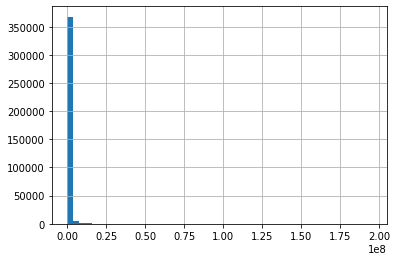

In [20]:
# Посмотрим на распределение признака
df.target.hist(bins = 50)

195000000.0 максимум
2799000.0 правый квантиль
363455


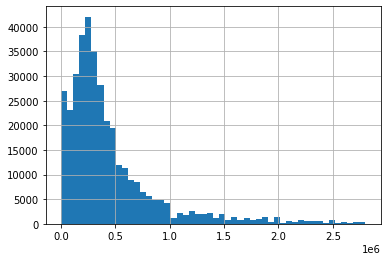

In [21]:
# Посмотрим на левую часть распределения
print(df.target.max(), 'максимум')
print(df.target.quantile(0.97),'правый квантиль')
print(df.target[df.target < 2799000.0 ].count())
df.target[df.target < 2799000.0 ].hist(bins = 50)
# Тут мы видим, что есть большое количество околонулевых значений.
# Это явно ошибки удалим их

1.0 минимум
20000.0 левый квантиль
11063


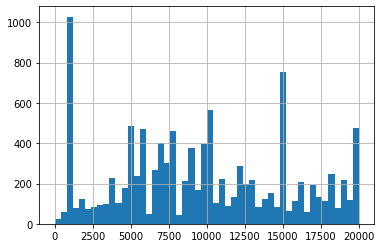

In [22]:
# Посмотрим на левую часть распределения
print(df.target.min(), 'минимум')
print(df.target.quantile(0.03),'левый квантиль')
print(df.target[df.target < 20000.0 ].count())
df.target[df.target < 20000.0 ].hist(bins = 50)
# Тут мы видим, что есть большое количество околонулевых значений.
# Это явно ошибки удалим их

In [809]:
# Удалим аномально высокие значения и маленькие
df = df.drop(df.loc[df.target > 2799000.0].index, axis = 0)
df = df.drop(df.loc[df.target < 20000.0].index, axis = 0)

In [810]:
len(df)

352445

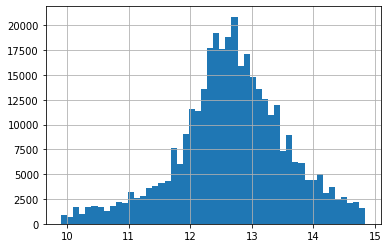

In [811]:
# Попробуем логарифмировать
np.log(df.target).hist(bins = 50)
# Распределение стало похоже на нормальное - хорошо.

## eda status

In [812]:
# Посмотрим сколько осталось домов к аренде.
df['status'][df['status'] == 'for rent']

22797     for rent
23667     for rent
180922    for rent
300847    for rent
Name: status, dtype: object

In [813]:
# Осталось только 4 обьекта их удалим. Тем более что мы хотим оценивать недвижимость к продаже а не к аренде.
df = df.loc[~df['status'].isin(['for rent'])]

## eda propertyType

In [814]:
df['status'].value_counts()

for sale    208644
active       97386
new           5969
Name: status, dtype: int64

## eda sqft

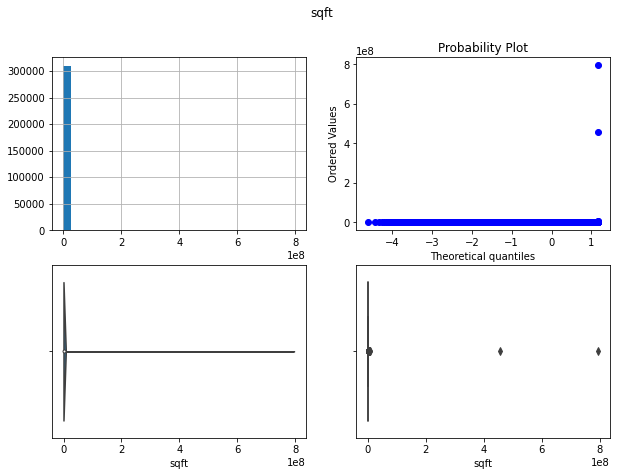

In [815]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'sqft', 'sqft')

In [816]:
# Посмотрим на границы выбросов.
# выбросов 14 тысяч это много поэтому попробуем с этим что то зделать.
get_quantile(df, 'sqft')

Верхняя граница выбросов: 4457.5 Нижняя граница выбросов: -610.5

Количество выбросов: sqft : 14021


In [817]:
# Посмотрим на значения 0.7 процента правой стороны распределения.
df.sqft.quantile(0.993)

8931.0

In [818]:
# Посмотрим на значения 0.1 процента левой стороны распределения.
df.sqft.quantile(0.001)

315.0

In [819]:
# Всего 2482 значений удалим их.
print(len(df[df.sqft > 8931]))
print(len(df[df.sqft < 150]))

2172
145


In [820]:
df = df.drop(df.loc[df.sqft > 8931].index, axis = 0)
df = df.drop(df.loc[df.sqft < 315.0].index, axis = 0)

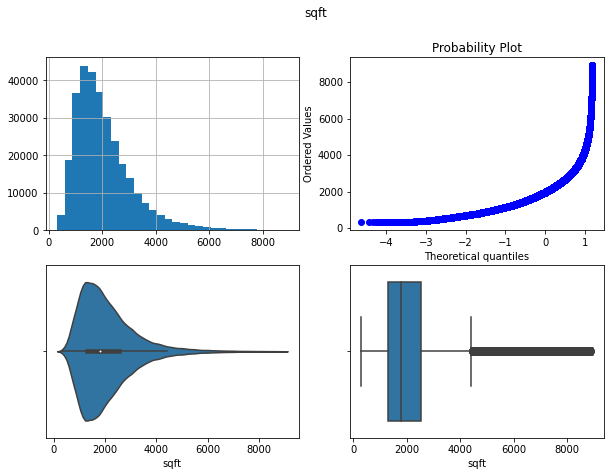

In [821]:
# График явно улучшился но есть правый хвост.
diagnostic_plots(df, 'sqft', 'sqft')

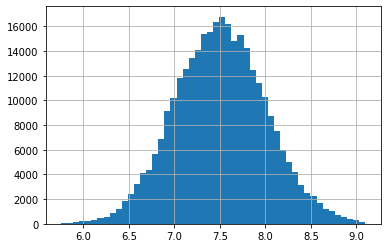

In [822]:
# Логарифмируем признак и получаем нормальное распределение - хорошо!
np.log(df.sqft).hist(bins = 50)

In [823]:
df.sqft = np.log(df.sqft)

## eda baths

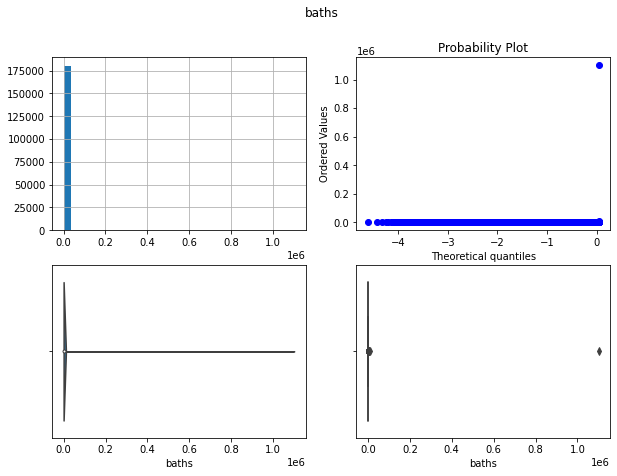

In [824]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'baths', 'baths')

In [825]:
# Посмотрим на границы выбросов.
# выбросов 13 тысяч это много поэтому попробуем с этим что то зделать.
get_quantile(df, 'baths')

Верхняя граница выбросов: 4.5 Нижняя граница выбросов: 0.5

Количество выбросов: baths : 13492


In [826]:
# Минимум максимум.
print(df.baths.max())
print(df.baths.min())

1101010.0
0.0


In [827]:
# Посмотрим на значения 0.01 процента правой стороны распределения.
df.baths.quantile(0.999)

750.0

In [828]:
# Посмотрим на значения 0.05 процента левой стороны распределения.
df.baths.quantile(0.05)

1.0

In [829]:

print(len(df[df.baths > 5]))
print(len(df[df.baths == 0]))

4639
2094


In [830]:
df.baths.median()

2.0

In [831]:
# Удалим значения больше 5
df = df.drop(df.loc[df.baths > 5].index, axis = 0)

In [832]:
df.baths = df.baths.apply(lambda x: 1 if x == 0 else x)
df.baths = df.baths.apply(lambda x: 4 if x > 5 else x)


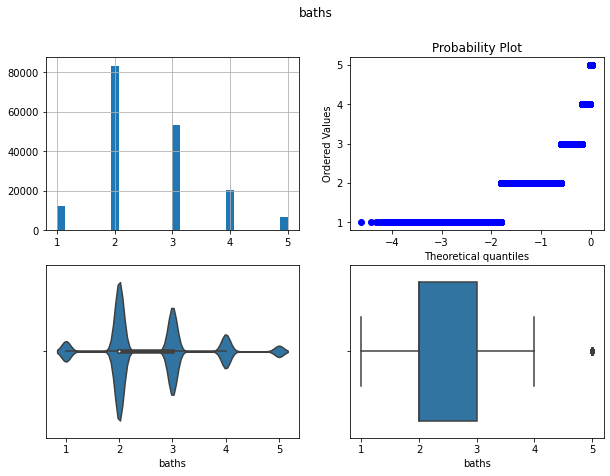

In [833]:
# График явно улучшился.
diagnostic_plots(df, 'baths', 'baths')

## beds

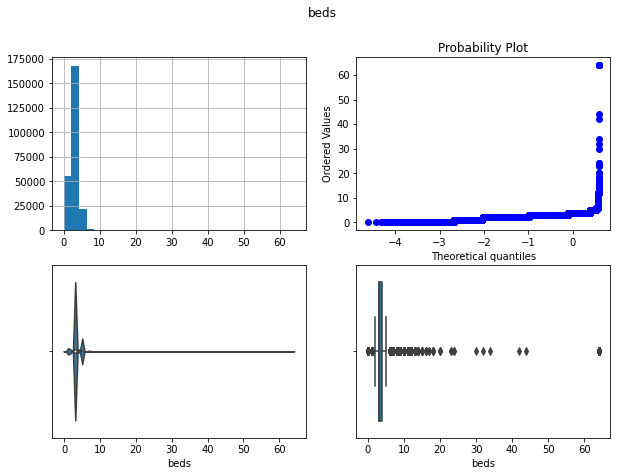

In [834]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'beds', 'beds')

In [835]:
print(df.beds.max())
print(df.beds.min())

64.0
0.0


In [836]:
print(df.beds.median())

3.0


In [837]:
print(df.beds[df.beds == 0].count())
print(df.beds[df.beds > 10].count())

1276
186


In [838]:
print(df.beds.quantile(0.999))
print(df.beds.quantile(0.001))

10.0
0.0


In [839]:
df = df.drop(df.loc[df.beds > 20].index, axis = 0)

In [840]:
#df.beds = df.beds.apply(lambda x: 1 if x == 0 else x)
df.beds = df.beds.apply(lambda x: 4 if x > 15 else x)

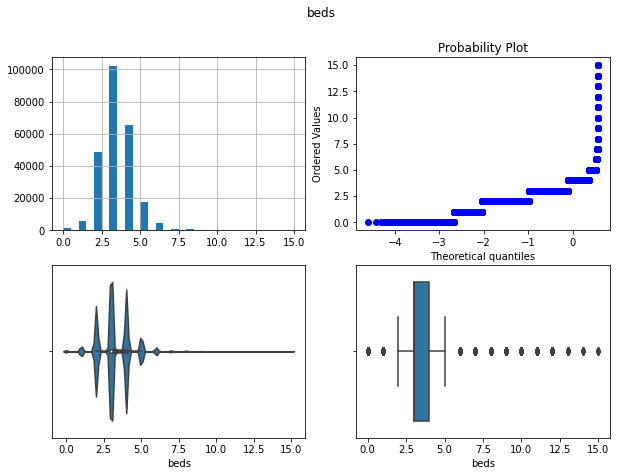

In [841]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'beds', 'beds')

## stories

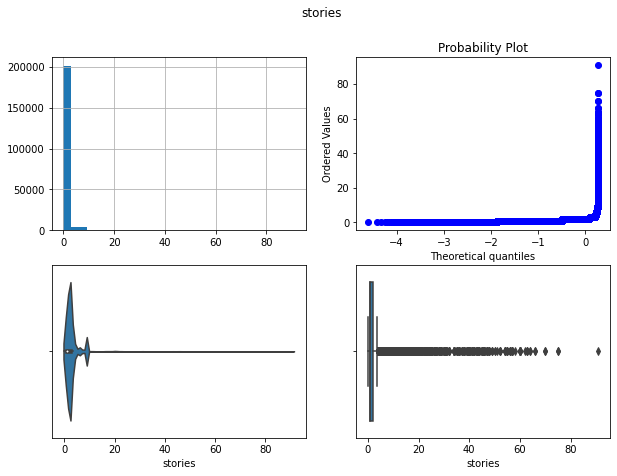

In [842]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'stories', 'stories')

In [843]:
print(df.stories.max())
print(df.stories.min())

91.0
0.0


In [844]:
print(df.stories.median())

1.0


In [857]:
print(df.stories[df.beds == 0].count())
print(df.stories[df.beds > 10].count())

684
71


In [846]:
print(df.stories.quantile(0.999))
print(df.stories.quantile(0.001))

38.0
0.0


In [847]:
get_quantile(df, 'stories')

Верхняя граница выбросов: 3.5 Нижняя граница выбросов: -0.5

Количество выбросов: stories : 9349


In [848]:
df = df.drop(df.loc[df.stories > 10].index, axis = 0)

In [849]:
df.stories = df.stories.apply(lambda x: 1 if x == 0 else x)
#df.stories = df.stories.apply(lambda x: 4 if x > 5 else x)

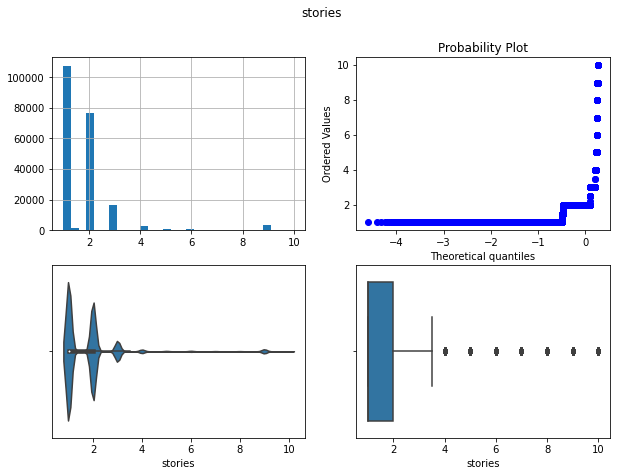

In [850]:
# Очевидные выбросы на графике
diagnostic_plots(df, 'stories', 'stories')

# Наивное решение

In [851]:
# Разделим признаки на числовые и категориальные
num_col = ['baths','sqft','beds','stories','PrivatePool','year_built','remodeled_year','lotsize','price_sqft','']
cat = ['status', 'propertyType', 'street', 'fireplace',
       'city', 'sqft', 'zipcode','state', 'heating', 'cooling',
       'parking', 'price_sqft', 'rating', 'name', 'data_distance',
       'data_grades','propertyType_1']


In [852]:
y = df.target
df.drop(['target'], inplace = True,axis = 1)

In [853]:
# Закодируем категориальные признаки.
for colum in cat:
  df[colum] = df[colum].astype('category').cat.codes

In [854]:
# split данных
X_train, X_test, y_train, y_test = train_test_split(df, np.log(y), test_size=0.2, shuffle=True, random_state=42)

In [858]:
model_cat = CatBoostRegressor(iterations = 20000,
                          learning_rate = 0.01,
                          l2_leaf_reg=2,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',

                         )
model_cat.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=1000,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.0542260	test: 0.0539865	best: 0.0539865 (0)	total: 53.7ms	remaining: 17m 54s
1000:	learn: 0.0318431	test: 0.0317228	best: 0.0317228 (1000)	total: 47.4s	remaining: 14m 59s
2000:	learn: 0.0297079	test: 0.0296119	best: 0.0296119 (2000)	total: 1m 34s	remaining: 14m 13s
3000:	learn: 0.0285488	test: 0.0284894	best: 0.0284894 (3000)	total: 2m 22s	remaining: 13m 28s
4000:	learn: 0.0278002	test: 0.0277878	best: 0.0277878 (4000)	total: 3m 10s	remaining: 12m 41s
5000:	learn: 0.0272388	test: 0.0272716	best: 0.0272716 (5000)	total: 4m	remaining: 12m
6000:	learn: 0.0268131	test: 0.0268889	best: 0.0268889 (6000)	total: 4m 47s	remaining: 11m 11s
7000:	learn: 0.0264693	test: 0.0265948	best: 0.0265948 (7000)	total: 5m 35s	remaining: 10m 22s
8000:	learn: 0.0261773	test: 0.0263529	best: 0.0263529 (8000)	total: 6m 21s	remaining: 9m 32s
9000:	learn: 0.0259264	test: 0.0261495	best: 0.0261495 (9000)	total: 7m 8s	remaining: 8m 44s
10000:	learn: 0.0257119	test: 0.0259861	best: 0.0259861 (10000)	tota

In [859]:
# Удручающий результат приступим к увф и посмотрим что можно зделать.
test_predict_catboost = model_cat.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 34.20%


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374704 entries, 0 to 374703
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          332863 non-null  object 
 1   propertyType    374704 non-null  object 
 2   street          372876 non-null  object 
 3   baths           189660 non-null  float64
 4   fireplace       374704 non-null  object 
 5   city            374670 non-null  object 
 6   sqft            321918 non-null  float64
 7   zipcode         374704 non-null  object 
 8   beds            263575 non-null  float64
 9   state           374704 non-null  object 
 10  stories         222653 non-null  float64
 11  PrivatePool     374704 non-null  float64
 12  target          374704 non-null  float64
 13  propertyType_1  298982 non-null  object 
 14  year_built      311416 non-null  float64
 15  remodeled_year  149833 non-null  float64
 16  heating         257558 non-null  object 
 17  cooling   

**Что планирую дальше делать:**

1. Еще надо поработать с датасетами из столбцов scools и homefacts.

2. Столбцы propertyType и status привел к нескольким категориям но из длинных строк потерялась информация попробую добавить еще dummy признаки из этих столбцов.

3. Буду продолжать eda

4. Далее поработаю с feature engineering.

5. Ну и следующим шагом начну тестировать алгоритмы.

